In [5]:
# download pip yang dibutuhkan, jika sudah punya gak usah di run
!pip install jcopdl
!pip install luwiji

# Import Package

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Import Dataset

In [7]:
df = pd.read_csv("house_price.csv", index_col="ID")
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
ID,,,,,,,,,,,,,,
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


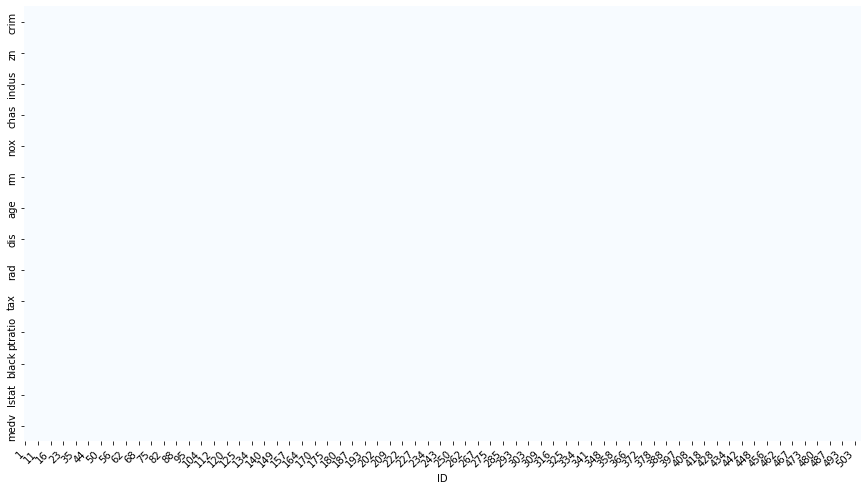

In [8]:
plot_missing_value(df)

# Splitting Data

In [9]:
x = df.drop(columns='medv')
y = df.medv

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((266, 13), (67, 13), (266,), (67,))

# Preprocessor & Train

In [22]:
num_pip = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler())
])

cat_pip = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("oneHot", OneHotEncoder())
])

preprocessor = ColumnTransformer([
    ('numeric', num_pip, ['crim', 'zn', 'indus', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'black', 'lstat']),
    ('categoric', cat_pip, ['chas'])
])

pipelines = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

params = {
    'algo__max_depth': [20, 50, 80],
    'algo__max_features': [0.3, 0.6, 0.8],
    'algo__min_samples_leaf': [1, 5, 10],
    'algo__n_estimators': [100, 150, 200]
    }

model = GridSearchCV(pipelines, params, cv=3, n_jobs=-1, verbose=1)
model.fit(x_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['crim',
                                                                          'zn',
                                                                          'indus',
                                                                          'nox',
                                                                          'rm',
        

In [23]:
print(model.best_params_)
print(model.score(x_train, y_train),model.best_score_, model.score(x_test, y_test))

{'algo__max_depth': 20, 'algo__max_features': 0.6, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 200}
0.9789763198446911 0.8395819996204615 0.9127390151263305


# save model

In [27]:
import pickle
import os

os.makedirs('model')

pickle.dump(model.best_estimator_, open('model/price_house_reg.sav', 'wb'))

In [28]:
loaded_model = pickle.load(open('model/price_house_reg.sav', 'rb'))
result = loaded_model.score(x_test, y_test)
print(result)

0.9127390151263304


In [37]:
x_train.head(5)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
ID,,,,,,,,,,,,,
340,0.05497,0.0,5.19,0,0.515,5.985,45.4,4.8122,5,224,20.2,396.90,9.74
118,0.15098,0.0,10.01,0,0.547,6.021,82.6,2.7474,6,432,17.8,394.51,10.30
456,4.75237,0.0,18.10,0,0.713,6.525,86.5,2.4358,24,666,20.2,50.92,18.13
28,0.95577,0.0,8.14,0,0.538,6.047,88.8,4.4534,4,307,21.0,306.38,17.28
43,0.14150,0.0,6.91,0,0.448,6.169,6.6,5.7209,3,233,17.9,383.37,5.81


In [39]:
sample = pd.DataFrame([[0.1,10,15,1,0.8,7,40,5,8,250,15,300,15]], columns=x_train.columns)
sample

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.1,10,15,1,0.8,7,40,5,8,250,15,300,15


In [42]:
loaded_model.predict(sample)

array([25.407])